## CS 169 - HW 2
## Sanath Nair

### Prefix

Below is some helper code from HW 1 to help make HW 2's code readable.

In [1]:
import math

def bracket_minimum(f, x=0, s=1e-2, k=2.0):
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    
    func_evals = 2
    while True:
        c, yc = b + s, f(b + s)
        func_evals += 1
        if yc > yb:
            return (a, c, func_evals) if a < c else (c, a, func_evals)
        
        a, ya, b, yb = b, yb, c, yc
        s *= k

def optimizer1D(func, a, b, tol=1e-3):
    gr = (math.sqrt(5) - 1) / 2 

    x1 = a + (1 - gr) * (b - a)
    x2 = a + gr * (b - a)

    f1 = func(x1)
    f2 = func(x2)
    func_evals = 2
    while abs(b - a) > tol:
        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + (1 - gr) * (b - a)
            f1 = func(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + gr * (b - a)
            f2 = func(x2)
        func_evals += 1

    return (a + b) / 2 , func_evals

Since I'm using Python for this project I will make a base class similar to what was done in the K&W book with Julia. Using this base class I will create children class that inherit from it. In addition I will be using numpy arrays to improve the performance of my code.

The line search algorithm below was derived from the line search algorith in K&W (p. 54) but modified to work with my helper methods above and also run in python.

In [2]:
# abstract base class package
from abc import ABC, abstractmethod # abstractmethods must be implemented by children classes
# numpy package
import numpy as np
from time import perf_counter # used for calculating exection time

class DescentMethod(ABC):
    
    def __init__(self) -> None:
        super().__init__()
        self.points = np.array([])

    @abstractmethod
    def minimize(self, func, x0, fprime):
        pass
    
    # helper functions to make implementation of descent algorithms easier
    
    def magnitude(self, vector):
        # linalg -> linear algebra subpackage in numpy
        return np.linalg.norm(vector)
    
    def line_search(self, func, x, direction):
        """
        performs line search and updates x-values
        
        func: n-dimension function
        x: list of n values
        direction: n-dim vector
        """
        def objective(alpha):
            # *() is tuple unpacking notation in python
            return func(*(x + alpha * direction))
        
        a, b, func_evals1 = bracket_minimum(objective)

        alpha, func_evals2 = optimizer1D(objective, a, b)

        return x + alpha * direction, func_evals1 + func_evals2

### 1a)

For this problem I plan on implementing a gradient descent algorithm that uses a line search algorithm to determine how far to step in that direction.

In [3]:
class GradientDescent(DescentMethod):
    def __init__(self, ep=1e-4) -> None:
        super().__init__()
        self.ep = ep

    def minimize(self, func, x0, fprime):
        start = perf_counter()
        x = x0
        self.points = x
        
        gradient = fprime(*x)
        magnitude_gradient = self.magnitude(gradient)
        prev_magnitude = 0

        func_evals = 1
        while abs(magnitude_gradient - prev_magnitude) > self.ep:
            # created a normalized negative gradient (i.e. direction of steepest descent)
            # normalized_gradient =  -1 * (gradient / magnitude_gradient)
            x, f_evals = self.line_search(func, x, -1 * gradient)
            self.points = np.vstack((self.points, x))
            
            # update gradient for next iteration
            prev_magnitude = self.magnitude(gradient)
            gradient = fprime(*x)
            magnitude_gradient = self.magnitude(gradient)

            func_evals += f_evals + 1
            
        end = perf_counter()

        return x, abs(magnitude_gradient - prev_magnitude), end - start, func_evals

### 1b)

The algorithm below was adapted from K&W (p. 74) using the Polak-Ribiere update and the following [youtube video](https://www.youtube.com/watch?v=ctU58q39QrU&list=PLHAS_3-nESXV6XgW53wSkZHazVE7ZkHAV&index=30) which implmenets the Fletcher-Reeves update but I still used Polak-Ribiere due to its better performance.

In [4]:
class ConjugateGradient(DescentMethod):
    def __init__(self, restart_frequency, x_tol = 0.0005, f_tol = 0.01, ep=1e-3) -> None:
        super().__init__()
        self.restart_frequency = restart_frequency
        self.x_tol = x_tol
        self.f_tol = f_tol
        self.ep = ep

    def minimize(self, func, x0, fprime):
        start = perf_counter()
        k = 0
        x = x0
        self.points = x

        gradient = fprime(*x)

        d = -1 * gradient
        d_magnitude = self.magnitude(d)
        prev_magnitude = 0
        func_evals = 1
        while abs(d_magnitude - prev_magnitude) > self.ep:
            x, f_evals = self.line_search(func, x, d)
            self.points = np.vstack((self.points, x))
            
            next_gradient = fprime(*x)
            if k % self.restart_frequency < (self.restart_frequency - 1): 
                beta = np.matmul(next_gradient.T,(next_gradient - gradient)) / np.matmul(gradient.T, gradient)
            else:
                # restart every n iterations using the steepest descent direction
                beta = 0
            
            gradient = next_gradient
            d = -1 * next_gradient + beta * d
            k += 1
            func_evals += f_evals + 1

            prev_magnitude = d_magnitude
            d_magnitude = self.magnitude(d)

        end = perf_counter()

        return x, abs(d_magnitude - prev_magnitude), end - start, func_evals
        

### 1c)

Below is a generic implementation of the Rosenbrcok function with default values of `a=1` and `b=5`

In [5]:
def rosenbrock_generator(*, a=1, b=5):
    """
    arguments a, b must be passed as keyword arguments
    """
    def rosenbrock(*args):
        total = 0
        for i in range(len(args) - 1):
            x1 = args[i]
            x2 = args[i+1]
            total += (a - x1)**2 + b*(x2 - (x1**2))**2
        return total
    
    return rosenbrock

def rosenbrock_gradient_generator(*, a=1, b=5):
    """
    arguments a, b must be passed as keyword arguments
    """
    def rosenbrock_gradient(*args):
        dx1 = -2*(a-args[0]) + 2*b*(args[1]-args[0]**2)*(-2*args[0])
        gradients = [dx1]
        for i in range(1, len(args) - 1):
            x_prev = args[i-1]
            x = args[i]
            x_next = args[i+1]
            dxn = 2*b*(x - x_prev**2) - 2*(a-x) - 4*b*x*(x_next - x**2)*x
            gradients.append(dxn)
        dxn = 2 * b * (args[-1] - args[-2]**2)
        gradients.append(dxn)
        return np.array(gradients)

    return rosenbrock_gradient

For the second function I used Booth's Function from K&W (p. 429). The equation is as follows: 
$ f(\mathbf{x}) = \sum_{i=1}^{n-1} \left[ (x_i + 2x_{i+1} - 7)^2 + (2x_i + x_{i+1} - 5)^2 \right] $

In [6]:
def booths(*args):
    result = 0
    for i in range(len(args) - 1):
        term = (args[i] + (2 * args[i + 1]) - 7)**2 + ((2 * args[i]) + args[i + 1] - 5)**2
        result += term
    return result

def booths_gradient(*args):
    n = len(args)
    gradient = np.zeros(n)

    # Compute the gradient for the first dimension
    gradient[0] = (2 * (args[0] + 2 * args[1] - 7)) + (4 * (2 * args[0] + args[1] - 5))

    # Compute the gradient for the intermediate dimensions
    for i in range(1, n - 1):
        term = (4 * (args[i-1] + 2 * args[i] - 7)) + (2 * (2 * args[i-1] + args[i] - 5))
        term2 = (2 * (args[i] + 2 * args[i+1] - 7)) + (4 * (2 * args[i] + args[i+1] - 5))
        gradient[i] = term + term2

    # Compute the gradient for the last dimension
    gradient[n - 1] = (4 * (args[n - 2] + 2 * args[n - 1] - 7)) + (2 * (2 * args[n - 2] + args[n - 1] - 5))

    return gradient

The gradient for both the Rosenbrock function and Booth's function were derived from the following work that I did (blue is Rosenbrock and white is Booth's).
![image.png](../pictures/gradient.jpeg)

The function below takes a list of different starting points and runs the two gradient descent methods collecting data and returning it back. 

***NOTE: (One limitation is that we don't know the true minimum for higher dimension functions so we cannot measure absolute error)***

In [7]:
import pandas as pd

def run_test(func, gradient, starting_points, * ,dimensions=10):
    descent1 = GradientDescent()
    descent2 = ConjugateGradient(dimensions)

    data = []
    data2 = []
    for starting_point in starting_points:
        res = descent1.minimize(func, starting_point , gradient)
        res2 = descent2.minimize(func, starting_point , gradient)

        data.append(res[1:])
        data2.append(res2[1:])

    columns = ['convergence measure', 'wall time', 'func evals']
    df, df2 = pd.DataFrame(data, columns=columns), pd.DataFrame(data2, columns=columns)
    
    mean_std_df1 = df.agg(['mean', 'std'])
    mean_std_df2 = df2.agg(['mean', 'std'])

    # Concatenate the results into a new DataFrame for comparison
    comparison_df = pd.concat([mean_std_df1, mean_std_df2], axis=0)
    comparison_df = comparison_df.T
    comparison_df.columns = ["GD Mean", "GD Std", "CGD Mean", "CGD Std"]
    return comparison_df

For the starting points since the Rosenbrock's minimum is at (1,1...,1) and a 2D Booth's is at (1,3) I will randomly generate points in the range of (-4, 4).

In [8]:
def generate_starting_points(N, dim, lower, upper):
    random_arrays = []

    for _ in range(N):
        # Generate a random array of size D with values between lower and upper
        random_array = np.random.uniform(lower, upper, dim)
        random_arrays.append(random_array)

    return random_arrays

starting_points = generate_starting_points(50, 10, -4, -4)

In [9]:
rosenbrock = rosenbrock_generator()
rosenbrock_gradient = rosenbrock_gradient_generator()

run_test(rosenbrock, rosenbrock_gradient, starting_points)

,GD Mean,GD Std,CGD Mean,CGD Std
convergence measure,0.000097,0.00000,0.000865,1.095210e-19
wall time,0.077128,0.00163,0.006742,1.278722e-04
func evals,9528.000000,0.00000,834.000000,0.000000e+00


In [10]:
run_test(booths, booths_gradient, starting_points)

,GD Mean,GD Std,CGD Mean,CGD Std
convergence measure,0.000076,0.000000,0.000365,0.000000
wall time,0.008330,0.000486,0.001989,0.000083
func evals,849.000000,0.000000,202.000000,0.000000


As you can see from the tables the average func_evals and wall time for CGD is significantly lower than GD. This is because of the properities of the CGD allow it to take less steps. One thing to note is that our CGD doesn't perform optimally as it theoretically can on quadratic equation because of the fixed restart which forces it to take a step in the steepest descent direction to allow it to generalize for all types of functions.

### EXTRA CREDIT

For extra credit I decieded to plot the difference between GD and CGD on a 2D Rosenbrock and Booth's function to visually understand the performance difference between the two.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def get_points(func, gradient, starting_point, * ,dimensions=2):
    descent1 = GradientDescent()
    descent2 = ConjugateGradient(dimensions)

    descent1.minimize(func, starting_point , gradient)
    descent2.minimize(func, starting_point , gradient)

    return descent1.points, descent2.points

def draw_contour_and_descent(func, points1, points2, true_min, title):
    min_x, max_x = np.min(points1[:,0]) - 0.5, np.max(points1[:,0]) + 0.5
    min_y, max_y = np.min(points1[:,1]) - 0.5, np.max(points1[:,1]) + 0.5

    n = 100
    X,Y = np.meshgrid(np.linspace(min_x, max_x, n), np.linspace(min_y, max_y ,n))

    Z = func(X,Y)

    print("Steps (GD) : ", len(points1))
    print("Steps (CGD): ", len(points2))

    plt.contour(X,Y,Z, 50)

    for i in range(len(points1) - 1):
        x1, y1 = points1[i]
        x2, y2 = points1[i+1]
        plt.plot([x1, x2], [y1, y2], marker="o", color="r", markersize=5)

    for i in range(len(points2) - 1):
        x1, y1 = points2[i]
        x2, y2 = points2[i+1]
        plt.plot([x1, x2], [y1, y2], marker="o", color="g",  markersize=5)

    plt.plot(true_min[0], true_min[1], color="black", marker="*", markersize=10) # minimum point
    plt.title(title)

Steps (GD) :  395
Steps (CGD):  13


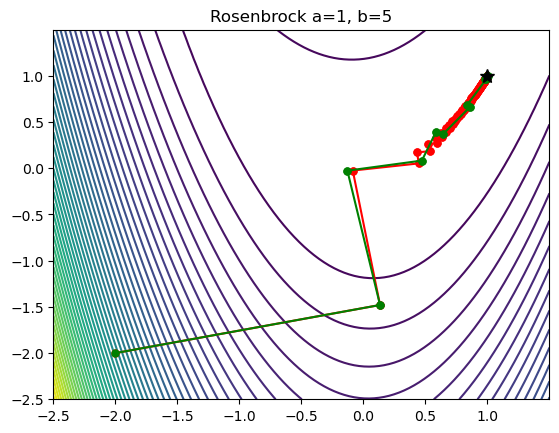

In [13]:
rosenbrock_points1, rosenbrock_points2 = get_points(rosenbrock, rosenbrock_gradient, [-2, -2])
draw_contour_and_descent(rosenbrock, rosenbrock_points1, rosenbrock_points2, (1,1), "Rosenbrock a=1, b=5")

Steps (GD) :  11
Steps (CGD):  5


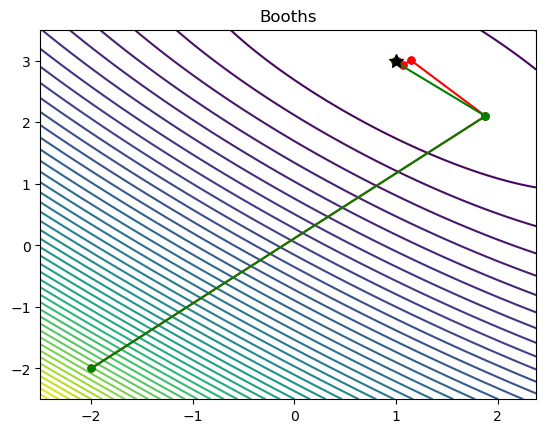

In [14]:
booths_points1, booths_points2 = get_points(booths, booths_gradient, [-2, -2])
draw_contour_and_descent(booths, booths_points1, booths_points2, (1,3), "Booths")

Its very apparent that CGD takes significantly less steps and converges faster to the true minimum point (the star). Specifically for the rosenbrock function we can see that there are less oscialations near the true minimum for CGD compared to GD (clusterin of red points near min vs few green points)